# Flowers Classfication

We a simple example to demonstrate how to use tensorflow datasets and tf2.3

@date: 01-Aug-2020 | @author: katnoria

In [207]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Dense, Flatten, Conv2D, BatchNormalization, Input
from tensorflow.keras import Model

In [2]:
def version_info(cls):
    print(f"{cls.__name__}: {cls.__version__}")

In [3]:
print("Version Used in this Notebook:")
version_info(tf)
version_info(tfds)

Version Used in this Notebook:
tensorflow: 2.3.0
tensorflow_datasets: 3.2.1


# Dataset

Tensorflow Datasets already provides this dataset in a format that we can use out of the box.

In [130]:
# Load the dataset
ds, info = tfds.load('tf_flowers', split='train', shuffle_files=True, with_info=True)

In [131]:
len(ds)

3670

Use the built in function to visualise the dataset 

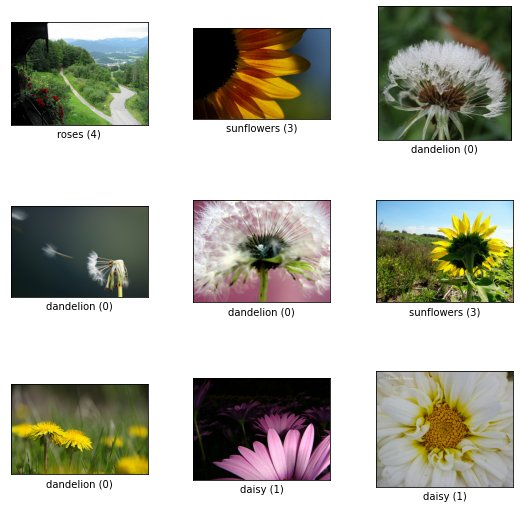

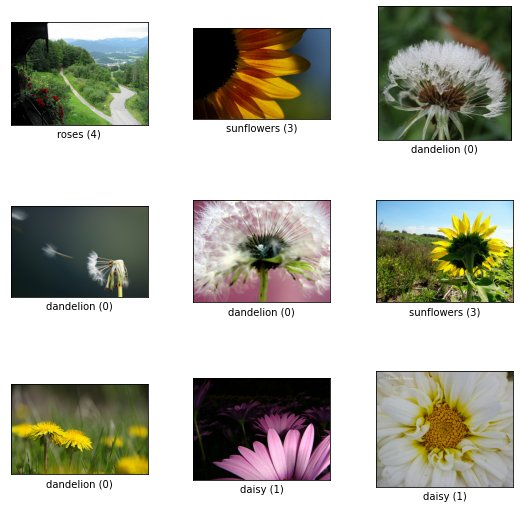

In [48]:
# Use the built-in 
tfds.show_examples(ds, info)

In [49]:
# Review metadata
# See https://www.tensorflow.org/datasets/overview
info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
})

In [50]:
print(f"Number of classes: {info.features['label'].num_classes}")
print(f"Labels: {info.features['label'].names}")
print(f"Int label to Str: {info.features['label'].int2str(3)}")
print(f"Str label to Int: {info.features['label'].str2int('sunflowers')}")

Number of classes: 5
Labels: ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']
Int label to Str: sunflowers
Str label to Int: 3


In [51]:
print(info.features['image'].shape)
print(info.features['image'].dtype)

(None, None, 3)
<dtype: 'uint8'>


In [52]:
print(info.splits)

{'train': <tfds.core.SplitInfo num_examples=3670>}


In [54]:
for example in ds.take(1):
    print(list(example.keys()))
    image = example['image']
    label = example['label']
    print(image.shape, label)

['image', 'label']
(212, 320, 3) tf.Tensor(3, shape=(), dtype=int64)


## Create Train and Test Splits

We now load the train and test splits and build the training pipeline. Flowers dataset does not provide train and test split so we will need to do it ourselves. And, that too is rather straightforward with the datasets library 🎉.

In [190]:
(ds_train, ds_test), info = tfds.load(
    'tf_flowers',
    split=[
        'train[:80%]',
        'train[-20%:]',        
    ],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

num_train_examples = len(ds_train)
num_test_examples = len(ds_test)
print(f"Training dataset size: {num_train_examples}")
print(f"Test dataset size: {num_test_examples}")

Training dataset size: 2936
Test dataset size: 734


In [191]:
info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
})

### Training Pipeline

In [192]:
def preprocess_image(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [128, 128])
    return image / 255., label

In [193]:
train_ds = ds_train.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
    .cache() \
    .shuffle(num_train_examples).batch(128) \
    .prefetch(tf.data.experimental.AUTOTUNE) 

In [194]:
example = train_ds.take(1)

In [195]:
list(example.keys())

AttributeError: 'TakeDataset' object has no attribute 'keys'

### Evaluation Pipeline

In [196]:
test_ds = ds_test.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
    .cache() \
    .batch(128) \
    .prefetch(tf.data.experimental.AUTOTUNE) 

# Build Model

We now build a simple convolution neural network

In [214]:
class FlowersModel(Model):
    def __init__(self):
        super(FlowersModel, self).__init__()
        self.conv1 = Conv2D(128, 64)
        self.bn1 = BatchNormalization()
        self.conv2 = Conv2D(64, 32)
        self.bn2 = BatchNormalization()        
        self.flatten = Flatten()
        self.dense1 = Dense(128, activation='relu')
        self.dense2 = Dense(64, activation='relu')        
        self.dense3 = Dense(5)
        
    def call(self, x, training=False):
        x = self.conv1(x)
        x = tf.nn.relu(self.bn1(x, training=training))
        x = self.conv2(x)
        x = tf.nn.relu(self.bn2(x, training=training))
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)        
        out = self.dense3(x)
        return out

In [215]:
model = FlowersModel()
first_batch = tf.zeros((1, 128, 128, 3))
model(first_batch)
model.summary()

Model: "flowers_model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           multiple                  1572992   
_________________________________________________________________
batch_normalization_8 (Batch multiple                  512       
_________________________________________________________________
conv2d_17 (Conv2D)           multiple                  8388672   
_________________________________________________________________
batch_normalization_9 (Batch multiple                  256       
_________________________________________________________________
flatten_8 (Flatten)          multiple                  0         
_________________________________________________________________
dense_16 (Dense)             multiple                  9470080   
_________________________________________________________________
dense_17 (Dense)             multiple              

Create the loss function and optimizer

In [216]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

We are going to measure the train and test accuracy of the model

In [217]:
# Train
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='train_acc')

# Test
test_loss = tf.keras.metrics.Mean(name='test_loss')
test_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='test_acc')

We now train the model

In [218]:
# Training step
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_fn(labels, predictions)
    # collect the gradients and apply
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    # loss & acc
    train_loss(loss)
    train_acc(labels, predictions)
    
    
# Test step    
@tf.function
def test_step(images, labels):
    predictions = model(images, training=False)
    loss = loss_fn(labels, predictions)
    # loss & acc
    test_loss(loss)
    test_acc(labels, predictions)

# Train the model

Now, its time to train the model for N epochs

In [219]:
num_epochs = 10

for epoch in range(num_epochs):
    train_loss.reset_states()
    train_acc.reset_states()
    test_loss.reset_states()
    test_acc.reset_states()
    
    for images, labels in train_ds:
        train_step(images, labels)
        
    for tst_images, tst_labels in test_ds:
        test_step(tst_images, tst_labels)
    
    print(f"Epoch {epoch+1}: \
            loss={train_loss.result():.4f}, accuracy: {train_acc.result():.4f} :: \ 
            test loss={test_loss.result():.4f}, test accuracy: {test_acc.result():.4f}")

Epoch 1:             train loss=7.3969, train accuracy: 0.2895 ::             test loss=1.7869, test accuracy: 0.2956
Epoch 2:             train loss=2.1359, train accuracy: 0.3815 ::             test loss=1.5353, test accuracy: 0.3093
Epoch 3:             train loss=1.5564, train accuracy: 0.4261 ::             test loss=1.5228, test accuracy: 0.3120
Epoch 4:             train loss=1.8000, train accuracy: 0.4254 ::             test loss=1.6477, test accuracy: 0.3297
Epoch 5:             train loss=1.6202, train accuracy: 0.4489 ::             test loss=1.5789, test accuracy: 0.2411
Epoch 6:             train loss=1.5974, train accuracy: 0.4646 ::             test loss=1.5901, test accuracy: 0.2384
Epoch 7:             train loss=1.5728, train accuracy: 0.4710 ::             test loss=1.6551, test accuracy: 0.2616
Epoch 8:             train loss=1.3527, train accuracy: 0.4908 ::             test loss=1.7561, test accuracy: 0.2684
Epoch 9:             train loss=1.2780, train accuracy: 